# Notebook to illustrate how you can look at internal network nodes

### KN, Nov 2016

Adapted from: https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [29]:
# boilerplate code
#from __future__ import print_function
#import os
from io import BytesIO
import numpy as np
#from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline
import tensorflow as tf
import matplotlib.pylab as plt

In [44]:
# Load pre-trained model
modelFP = '/Users/kateniehaus/General_code/data/tensorflow_inception_graph.pb'

# Make session
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

# Open file
with tf.gfile.FastGFile(modelFP, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
# Make placeholder
t_input = tf.placeholder(np.float32, name='input')

# Magic numbers
imagenet_mean = 117.0
im_width = 224
num_origChannels = 3

# ?? What does this do?
t_preprocessed = tf.expand_dims(t_input-imagenet_mean,0)

tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [42]:
# get the names of all the layers
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
# --> Op types seem to include: 'AvgPool', 'BiasAdd', 'Concat', 'Const', 'Conv2D', 'ExpandDims', 'Identity', 'LRN'
# 'MatMul', 'MaxPool', 'Placeholder', 'Relu', 'Reshape', 'Softmax', 'Sub'
#np.unique(np.array(([op.type for op in graph.get_operations()])))

# get how many features are in each layer (named as Dimension)
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]
#graph.get_tensor_by_name(layers[0]+':0').get_shape()

print('Total num layers : {0}'.format(len(layers)))
print('Total num feature channels: {0}'.format(sum(feature_nums)))
for i, feat_n in enumerate(feature_nums):
    print('Layer {0}: {1} - {2}'.format(i, feat_n, layers[i]))


#layers[0]+':1'

Total num layers : 59
Total num feature channels: 7548
Layer 0: 64 - import/conv2d0_pre_relu/conv
Layer 1: 64 - import/conv2d1_pre_relu/conv
Layer 2: 192 - import/conv2d2_pre_relu/conv
Layer 3: 64 - import/mixed3a_1x1_pre_relu/conv
Layer 4: 96 - import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer 5: 128 - import/mixed3a_3x3_pre_relu/conv
Layer 6: 16 - import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer 7: 32 - import/mixed3a_5x5_pre_relu/conv
Layer 8: 32 - import/mixed3a_pool_reduce_pre_relu/conv
Layer 9: 128 - import/mixed3b_1x1_pre_relu/conv
Layer 10: 128 - import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer 11: 192 - import/mixed3b_3x3_pre_relu/conv
Layer 12: 32 - import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer 13: 96 - import/mixed3b_5x5_pre_relu/conv
Layer 14: 64 - import/mixed3b_pool_reduce_pre_relu/conv
Layer 15: 192 - import/mixed4a_1x1_pre_relu/conv
Layer 16: 96 - import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer 17: 204 - import/mixed4a_3x3_pre_relu/conv
Layer 18: 16 - import/mix

In [18]:
# Handy functions

def returnLayer(layer):
    '''Helper for getting layer output tensor  (original function name: 'T')'''
    return graph.get_tensor_by_name("import/{0}:0".format(layer))

## Image-space gradient ascent method

In [19]:
tf.reduce_mean?

In [39]:
# Specific functions

def gradAscentMethod(t_obj, t_input, img0, iter_n=20, step=1.0):
    """ Returns optimized image (original function: 'render_naive')"""
    # define the optimization objective: element mean
    t_score = tf.reduce_mean(t_obj) # compute mean of elements across dimensions of tensor 
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        #print(score)
    return img


def showarray(a, fmt='jpeg'):
    """ TODO: Don't really understand what is going on here """
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
    
def normImage(a, s=0.1):
    '''Normalize the image range for visualization (original function: visstd)'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5
    

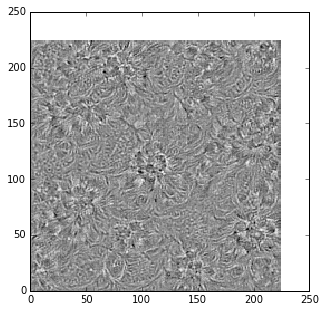

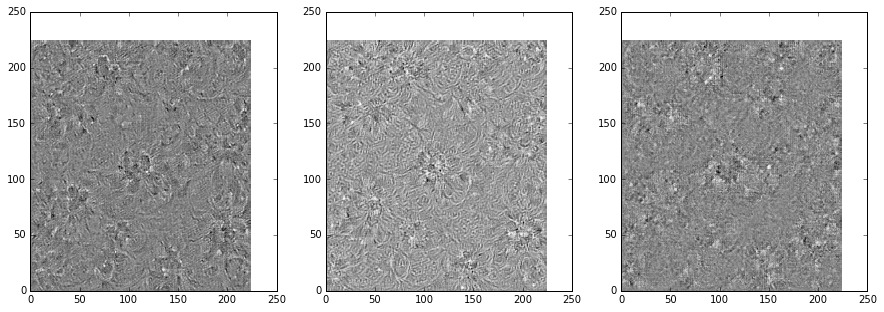

In [54]:
# best to use outputs before applying the ReLU nonlinearity 
# to have non-zero gradients for features with negative initial activations.

layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139  # picking some feature channel to visualize

# idea, optimize this image to activate layers
offset = 100
img_noise = np.random.uniform(size=(im_width,im_width,num_origChannels)) + offset

# get layer
layerObj = returnLayer(layer)[:,:,:,channel]
# do gradient ascent
imgA = gradAscentMethod(layerObj, t_input, img0=img_noise)

# plot visualization
plt.figure(figsize=[5,5])
plt.pcolormesh(np.mean(normImage(imgA), axis=2), cmap='Greys')
plt.figure(figsize=[15,5])
for i in range(num_origChannels):
    plt.subplot(1,3,i+1)
    plt.pcolormesh(normImage(imgA[:,:,i]), cmap='Greys')